- Use epl_dataset to read data and measure correlations of linear model, RNN

In [1]:
from epl_dataset import epl_dataset, model_utils
import prediction_models
import torch
import torch.nn as nn
import pytorch_lightning as pl
import numpy as np
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import seaborn as sns
from matplotlib import pyplot as plt

torch.manual_seed(0)
np.random.seed(0)

In [2]:
input_feature_names = ["total_points", "minutes", "ict_index", "clean_sheets", "saves"]
window_size = 5 
batch_size = 500
train_loader, test_loader, (means, stds) = epl_dataset.get_dataset(data_path="../data/", 
    input_feature_names=input_feature_names, 
    window_size=5, batch_size=28, force_download=True)
train_loader, test_loader

Cloning into '../tmp/Fantasy-Premier-League'...
/home/ajrfhp/anaconda3/envs/test/lib/python3.8/site-packages/epl_dataset/epl_dataset.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historical_player_features.fillna(0, inplace=True)
/home/ajrfhp/anaconda3/envs/test/lib/python3.8/site-packages/epl_dataset/epl_dataset.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historical_player_features["total_points"] = historical_player_features["total_points"].clip(0, max_player_points)


(<torch.utils.data.dataloader.DataLoader at 0x7f9558b92610>,
 <torch.utils.data.dataloader.DataLoader at 0x7f946401d5b0>)

- Benchmark avg, linear, prev, RR on this dataset

In [3]:
avg_model = prediction_models.AvgModel()
prev_model = prediction_models.PrevModel()
linear_model = prediction_models.LinearModel(window_size=window_size-1, num_features=len(input_feature_names))
rnn_model = prediction_models.RNNModel(window_size=window_size-1, num_features=len(input_feature_names))

for model in [avg_model, prev_model, linear_model, rnn_model]:
    model_type = [ k for k, v in locals().items() if v == model][0]

    model = model_utils.LightningWrapper(window_size=window_size-1, model = model, player_feature_names=input_feature_names)
    logger = pl.loggers.TensorBoardLogger(f"lightning_logs/model_comparison/{model_type}")
    trainer = pl.Trainer(max_epochs=50, gpus=torch.cuda.device_count(), logger=logger, callbacks=[EarlyStopping(monitor="val_loss", patience=10)])
    if model_type in ['linear_model', 'rnn_model']:
        trainer.fit(model, train_loader, test_loader)
    trainer.validate(model, test_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating:  99%|█████████▉| 425/429 [00:01<00:00, 427.72it/s]--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'train_loss': 0.8425578474998474, 'val_loss': 0.8425578474998474}
--------------------------------------------------------------------------------
                                                              

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 100%|█████████▉| 427/429 [00:01<00:00, 332.54it/s]--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'train_loss': 1.2487646341323853, 'val_loss': 1.2487646341323853}
--------------------------------------------------------------------------------
                                                              

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params
--------------------------------------
0 | model | LinearModel | 21    
--------------------------------------
21        Trainable params
0         Non-trainable params
21        Total params
0.000     Total estimated model params size (MB)


Epoch 10: 100%|██████████| 2144/2144 [00:12<00:00, 168.93it/s, loss=0.743, v_num=6]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'train_loss': 0.7221452593803406, 'val_loss': 0.7221452593803406}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | RNNModel | 186   
-----------------------------------
186       Trainable params
0         Non-trainable params
186       Total params
0.001     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 2144/2144 [00:18<00:00, 117.86it/s, loss=0.725, v_num=6]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'train_loss': 0.716728687286377, 'val_loss': 0.716728687286377}
--------------------------------------------------------------------------------


- Visualize Predictions
    - For each model, get 5 predictions and bottom 5 predictions and try and interpret them

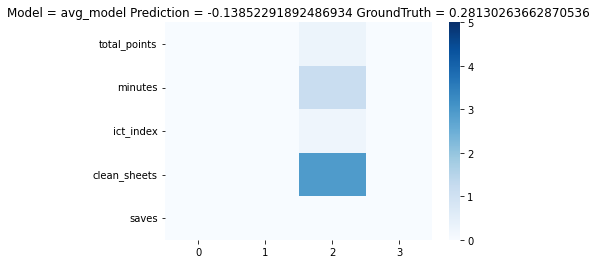

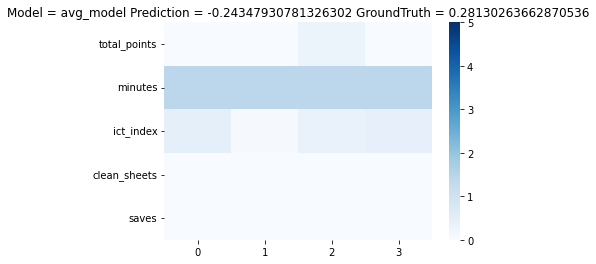

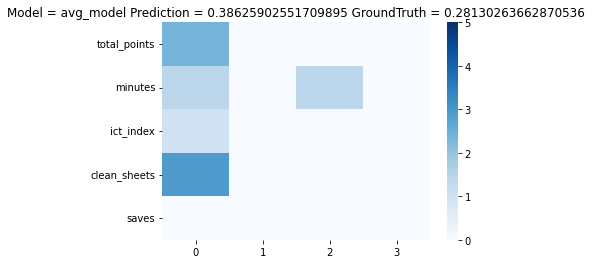

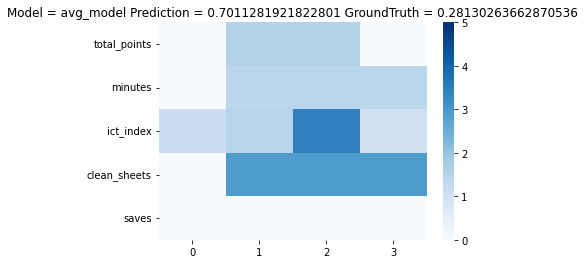

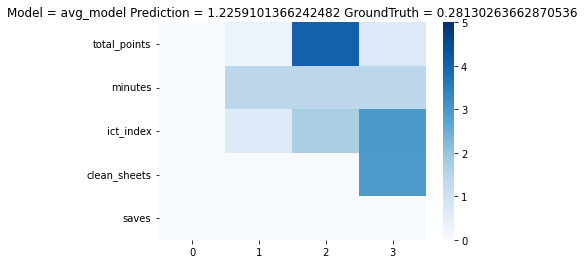

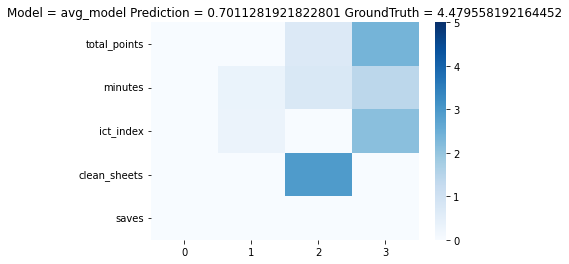

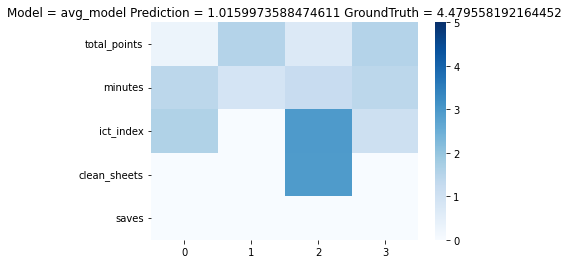

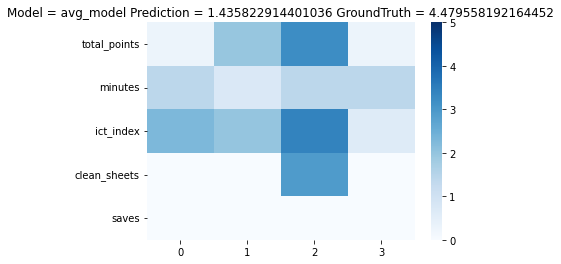

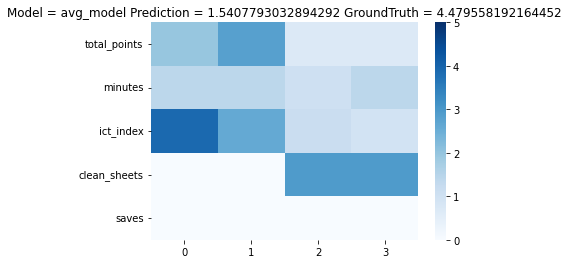

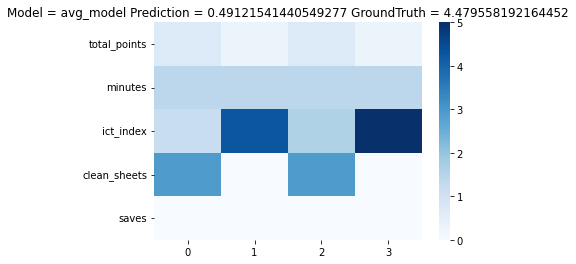

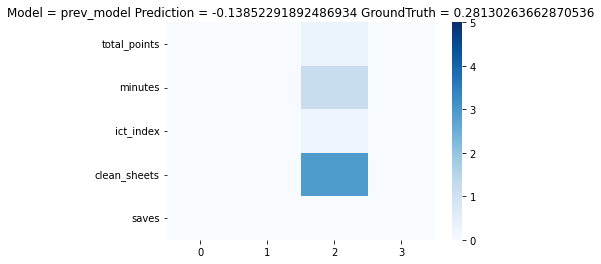

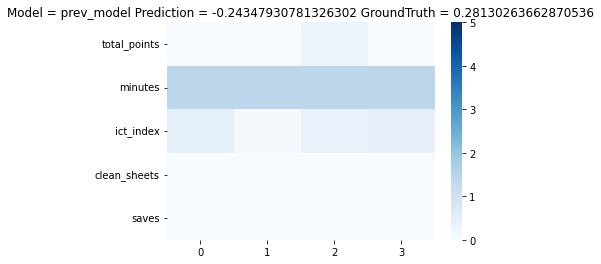

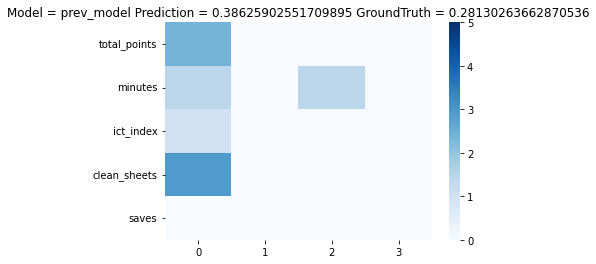

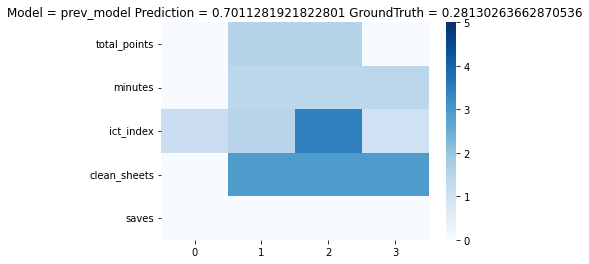

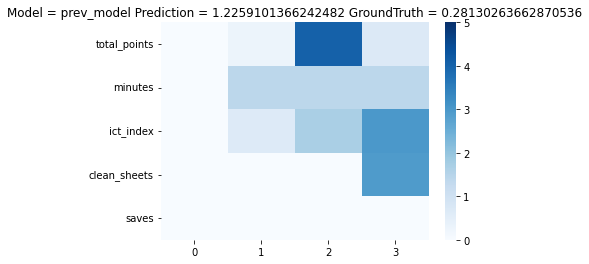

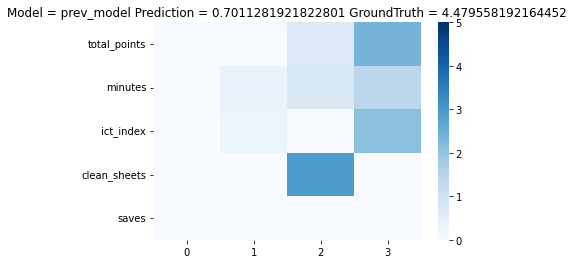

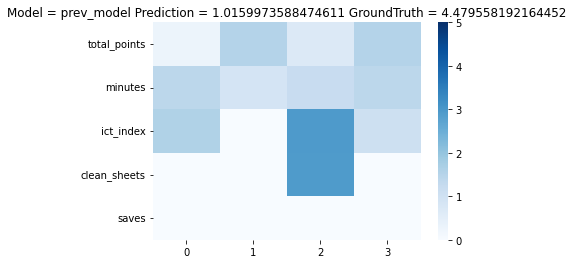

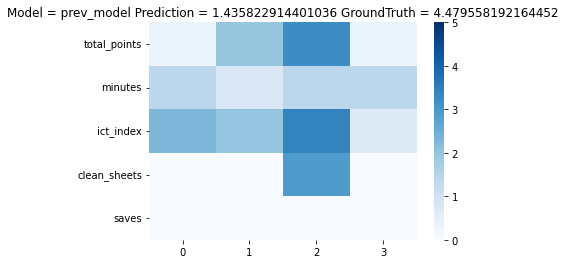

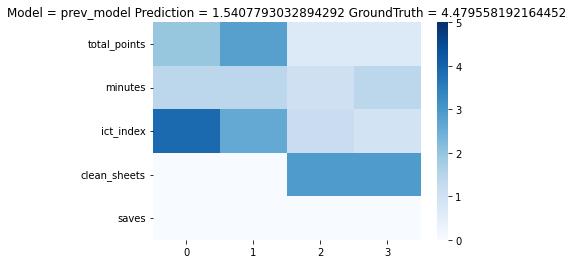

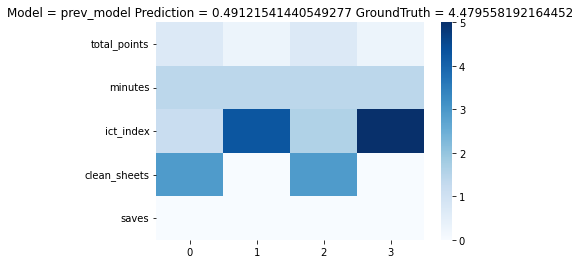

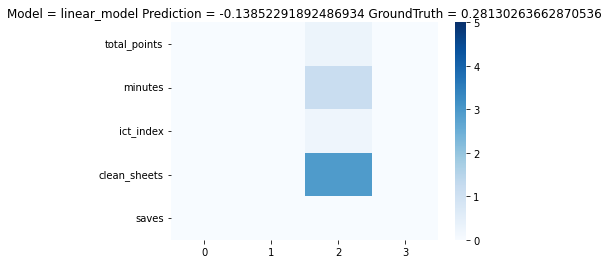

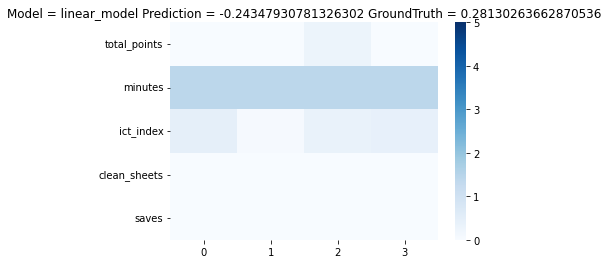

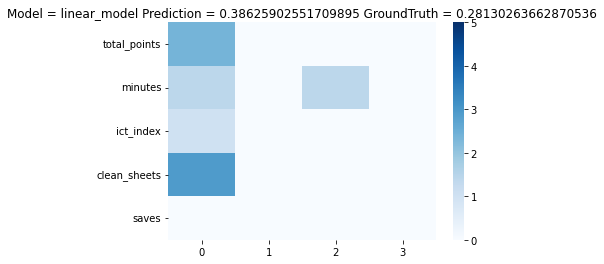

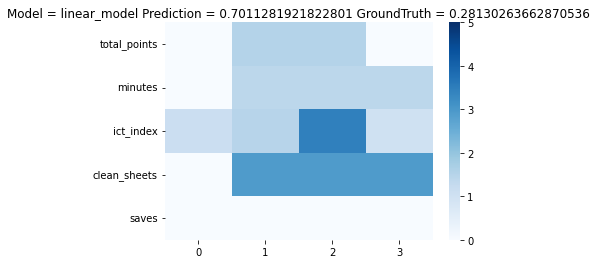

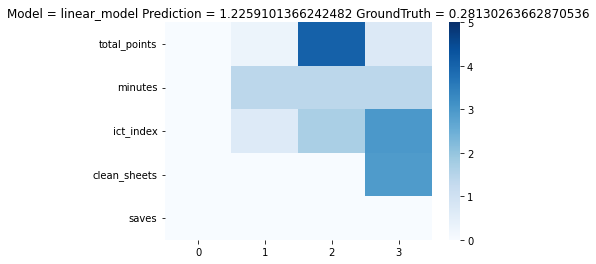

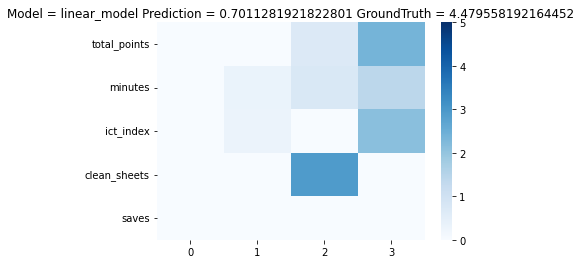

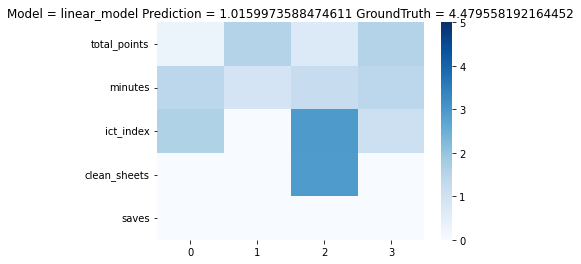

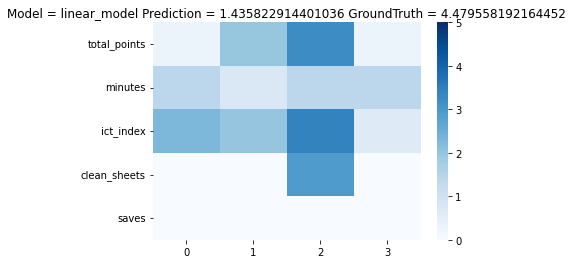

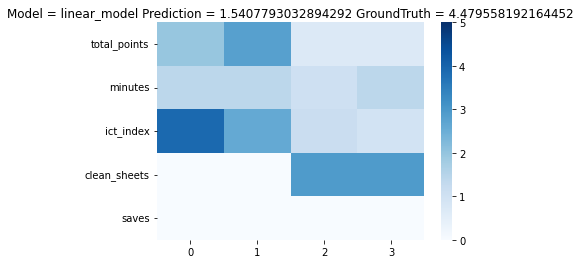

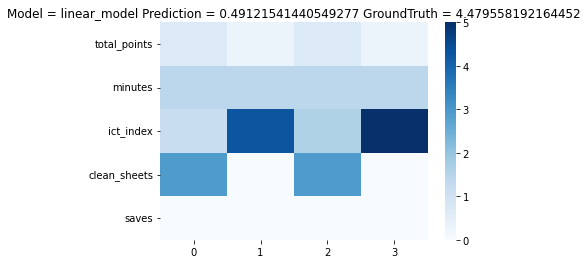

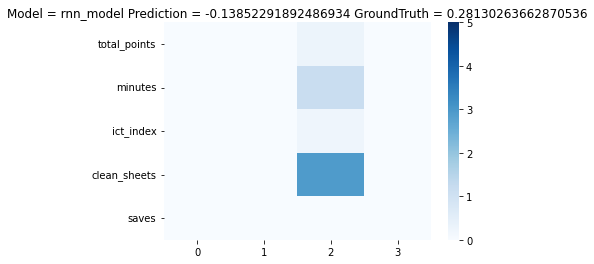

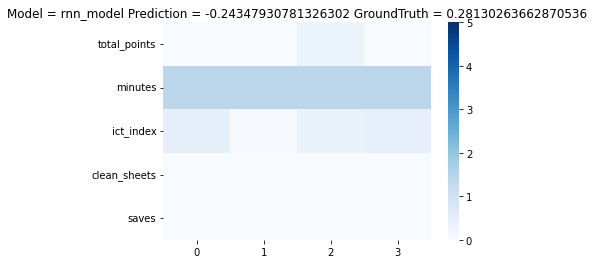

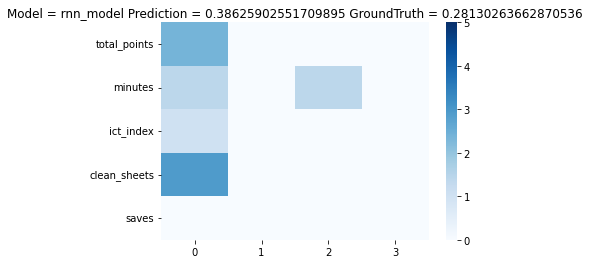

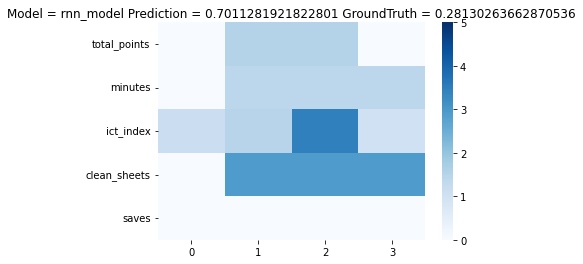

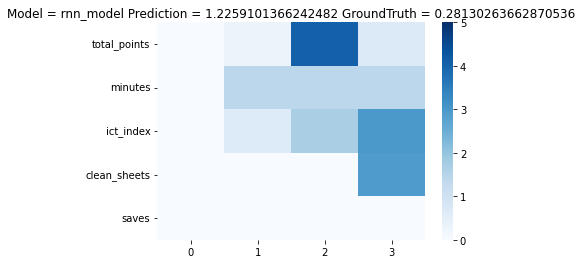

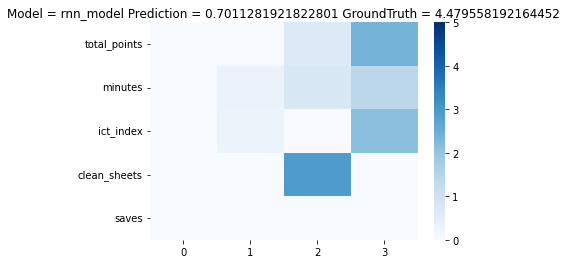

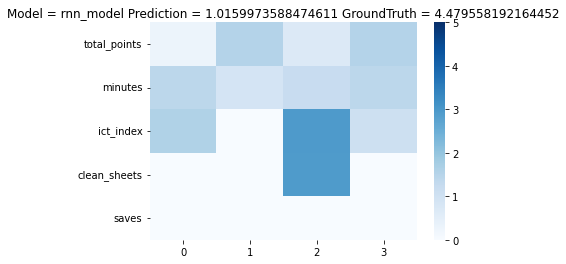

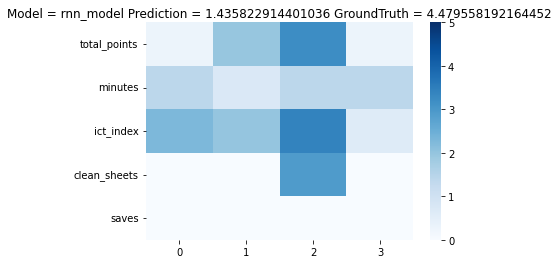

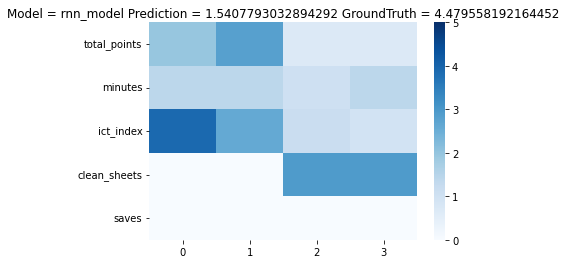

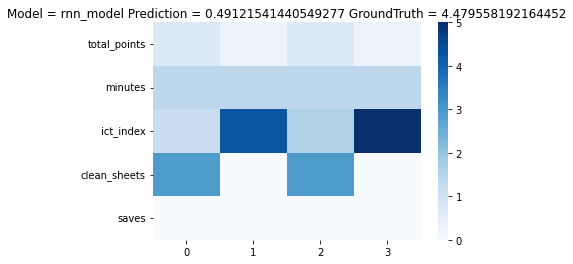

In [27]:
def visualize_top_k_predictions(model, input_feature_names, model_string, test_loader, sample_batch_count = 10, k=5, num_features=5, window_size=4):
    sample_inputs, sample_predictions, sample_outputs = torch.empty((0,num_features, window_size)), torch.empty((0,)), torch.empty((0,))
    for batch_count, (inputs, outputs) in enumerate(test_loader):
        predictions = model.forward(inputs)
        sample_predictions = torch.cat((sample_predictions, predictions))
        sample_inputs = torch.cat((sample_inputs, inputs))
        sample_outputs = torch.cat((sample_outputs, outputs))
        if batch_count >= sample_batch_count:
            break
    mask = sample_outputs.ge(0)
    sample_inputs = sample_inputs[mask,:]
    sample_outputs, sample_predictions = sample_outputs[mask], sample_predictions[mask]
    diff = torch.abs(sample_predictions - sample_outputs)
    sorted_indices = sample_outputs.argsort(dim=0)
    sample_inputs, sample_predictions, sample_outputs = sample_inputs[sorted_indices], sample_predictions[sorted_indices], sample_outputs[sorted_indices]
    best_inputs, best_predictions, best_outputs = sample_inputs[:k], sample_predictions[:k], sample_outputs[:k]
    worst_inputs, worst_predictions, worst_outputs = sample_inputs[-k:], sample_predictions[-k:], sample_outputs[-k:]

    for dataset in [(best_inputs, best_outputs, best_predictions),
                     (worst_inputs, worst_outputs, worst_predictions)]:
        (inputs, outputs, predictions) = dataset
        for input, output, prediction in zip(inputs, outputs, predictions):
            sns.heatmap(input, cmap='Blues', yticklabels=input_feature_names, vmin=0, vmax=5)
            plt.title(f'Model = {model_string} Prediction = {prediction} GroundTruth = {output}')
            plt.show()

for (model, model_string) in [(avg_model, 'avg_model'), (prev_model, 'prev_model'), (linear_model, 'linear_model'), (rnn_model, 'rnn_model')]:
    visualize_top_k_predictions(avg_model, input_feature_names, model_string, test_loader)